In [1]:
import os
import pickle
import numpy as np
from collections import Counter

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
def rougeScores(genSummary, refSummary):
    genTotal, refTotal, intersection = 0., 0., 0.
    for token in list(set(list(refSummary.keys()) + list(genSummary.keys()) )):
        intersection += min(refSummary[token], genSummary[token])
        refTotal += refSummary[token]
        genTotal += genSummary[token]

    recall = intersection / refTotal if refTotal > 0. else 0.
    prec   = intersection / genTotal if genTotal > 0. else 0.
    f1 = (2. * recall * prec) / (recall + prec) if (recall + prec) > 0. else 0.
    
    return recall, prec, f1

class BoWRegressor(nn.Module):  # inheriting from nn.Module!
    # calls the init function of nn.Module.  Dont get confused by syntax, always do it in an nn.Module
    def __init__(self, input_size, outputsize):        
        super(BoWRegressor, self).__init__()        
        self.linear = nn.Linear(input_size, outputsize)
        
    def forward(self, bow_vec):
        return self.linear(bow_vec)
#         return F.sigmoid(self.linear(bow_vec))


def buildPredSummary(df, summary, sentence_emb, curr_pred_emb, action, select_index, sent_index):
    if sent_index==0 and action.select(1, select_index).tolist()[0] == 1:
        return sentence_emb, summary + df['sentence'][sent_index]

    if action.select(1, select_index).tolist()[0] == 1:
        # This uses the avergae of the embeddings from the previous 
        # steps...but maybe we should try something different
        return (curr_pred_emb + sentence_emb)/2., curr_summary + ' ' + df['sentence'][sent_index]
    
    else:
        return sentence_emb, curr_summary

In [8]:
sdf = pd.read_csv('/home/francisco/GitHub/DQN-Event-Summarization/data/sif/train_000_0.csv')

# Initializing stuff

SKIP = 0
SELECT = 1

true_summary = sdf['summary'][0]
ts_tokenized = Counter(true_summary.split(" "))

nepochs = 1000
emb_d = 300
input_dim = 600

outputdim = 2
rand_rate = 0.50
decay_rate = 0.025

lrate = 0.01
momentum_rate = 0.8

criterion = nn.MSELoss()
nsentences = sdf.index.max()

In [9]:
model = BoWRegressor(input_dim, outputdim)
model.zero_grad()

# swap to ADAM
optimizer = optim.Adam(model.parameters(), lr=lrate)

lossf = {'loss': [], 'sent_idx': [], 'epoch': [], 'action': [], 'f1': [], 'optpred': [], 'rouge_delta':[]}
for epoch in range(nepochs):
    # reset embeddings and summary at the start of training
    f1_t0 = 0.
    curr_summary = ''
    predsummary_emb = torch.from_numpy(np.zeros((1, emb_d))).float()
    
    for sent_index in range(nsentences):        
        model.zero_grad()
        
        # The embeddings start on the 5th column (index 4)
        sent_emb = torch.FloatTensor(sdf[sdf.columns[4:]].values[sent_index, :].reshape(1, emb_d))
        train_xs = torch.cat([sent_emb, predsummary_emb], dim=1)
        train_ys = torch.from_numpy(np.asarray([0]).reshape(1, 1)).float()
        action = torch.from_numpy(np.asarray([0, 0]).reshape(1,2)).int()

        rouge_preds = model(autograd.Variable(train_xs))
        qMax, qIndx = rouge_preds.max(dim=1)

        if np.random.uniform() > rand_rate and rand_rate > 0:
            # Randomly choosing either 0 or 1 some percent of hte time
            qIndx = np.random.randint(0, 2, 1)[0]

        action[:, qIndx.data[0]] = 1
        action[:, abs(qIndx.data[0] - 1)] = 0
        
        # building the summary and capturing the embedding
        # without a history model doesn't make a lot of sense
        # not clear what's happening...
        # concatenate summary embedding to input or try separate joining layer like before
        # Worth looking at rougue of each sentence...calculate f1 for each sentence to find out
            # might help figure out what's going on...
        predsummary_emb, curr_summary = buildPredSummary(
                                             sdf, 
                                             curr_summary, 
                                             sent_emb, 
                                             predsummary_emb, 
                                             action, 
                                             SELECT, 
                                             sent_index
                                        )

        recall, prec, f1 = rougeScores(ts_tokenized, Counter(curr_summary.split(" ")))
        
        # Backward part
        predQonActions = torch.masked_select(rouge_preds, autograd.Variable(action.byte()))
        rouge_delta = f1 - f1_t0
        
        # Change in rouge-f1
        train_ys[0] = rouge_delta

        loss = criterion(predQonActions, autograd.Variable(train_ys))
        
        loss.backward()
        optimizer.step()
        
        lossf['loss'].append(loss.data[0])
        lossf['sent_idx'].append(sent_index)
        lossf['epoch'].append(epoch)
        lossf['action'].append(qIndx.data[0])
        lossf['f1'].append(f1)
        lossf['optpred'].append(predQonActions.data[0])
        lossf['rouge_delta'].append(rouge_delta)

        # Storing last round
        f1_t0 = f1 - f1_t0
        
    rand_rate -= decay_rate

RuntimeError: size mismatch, m1: [1 x 300], m2: [600 x 2] at /opt/conda/conda-bld/pytorch_1503970438496/work/torch/lib/TH/generic/THTensorMath.c:1293

In [5]:
perf = pd.DataFrame(lossf)

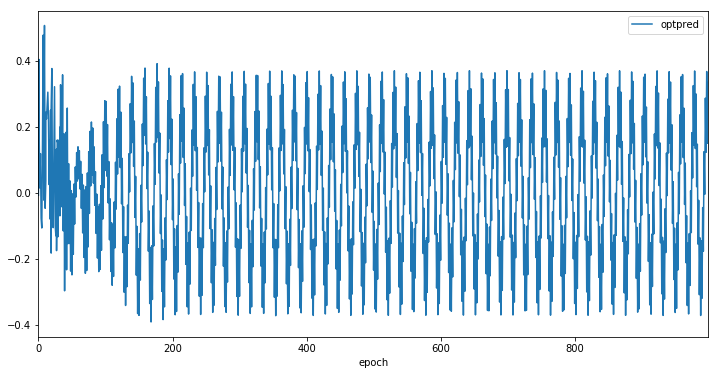

In [6]:
perf[(perf['sent_idx'] == perf['sent_idx'].max() & (perf['action']==0))].plot(x='epoch', y='optpred', figsize=(12, 6))

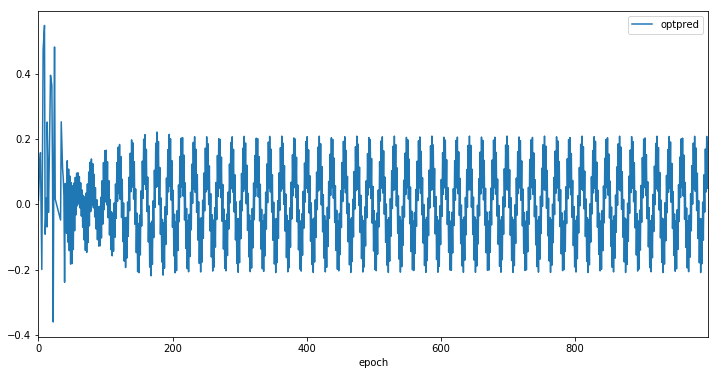

In [7]:
perf[(perf['sent_idx'] == perf['sent_idx'].max() & (perf['action']==1))].plot(x='epoch', y='optpred', figsize=(12, 6))

In [ ]:
perf[(perf['sent_idx'] == perf['sent_idx'].max() & (perf['action']==0))].plot(x='epoch', y='loss', figsize=(12, 6))
plt.grid()
plt.show()

In [ ]:
perf[(perf['sent_idx'] == perf['sent_idx'].max() & (perf['action']==1))].plot(x='epoch', y='loss', figsize=(12, 6))
plt.grid()
plt.show()

In [ ]:
perf = pd.DataFrame(lossf)

perf[perf['sent_idx'] == perf['sent_idx'].max()].plot(y='loss', figsize=(12, 6))
plt.grid()
plt.show()

In [ ]:
perf[perf['sent_idx'] == perf['sent_idx'].max()].plot(y='f1', figsize=(12, 6))
plt.grid()
plt.show()

In [ ]:
perf[perf['epoch'] == perf['epoch'].max()].plot(y='action', figsize=(12, 6))
plt.grid()
plt.show()

In [ ]:
lead3 = ' '.join(sdf['sentence'][0:3])

finalsummary = rougeScores(ts_tokenized, Counter(curr_summary.split(" ")))
baseline = rougeScores(ts_tokenized, Counter(lead3.split(" ")))

print("lead-3  recall = %.3f; precision = %.3f; f1-score = %.3f " % (baseline[0], baseline[1], baseline[2]))

print("learned recall = %.3f; precision = %.3f; f1-score = %.3f " % (finalsummary[0], finalsummary[1], finalsummary[2]))

In [ ]:
lead3

In [ ]:
true_summary

In [ ]:
curr_summary